In [ ]:
# Script to remove images smaller than 100x100 pixels
import os
from PIL import Image
import shutil
import time

def removeSmallImages(folderPath, minWidth=100, minHeight=100):
    """Remove images that are smaller than the specified dimensions"""
    removedCount = 0
    errorCount = 0
    totalCount = 0
    removedFiles = []
    
    for root, dirs, files in os.walk(folderPath):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                filePath = os.path.join(root, file)
                totalCount += 1
                
                try:
                    with Image.open(filePath) as img:
                        width, height = img.size
                        
                        if width < minWidth or height < minHeight:
                            img.close()
                            time.sleep(0.1)
                            
                            for attempt in range(3):
                                try:
                                    os.remove(filePath)
                                    removedCount += 1
                                    removedFiles.append(f"{file} ({width}x{height})")
                                    print(f"Removed: {filePath} - Size: {width}x{height}")
                                    break
                                except PermissionError:
                                    if attempt < 2:
                                        time.sleep(0.5)
                                        continue
                                    else:
                                        print(f"Permission denied: {filePath} - Could not remove after 3 attempts")
                                        errorCount += 1
                            
                except Exception as e:
                    errorCount += 1
                    print(f"Error processing {filePath}: {e}")
    
    return {
        'total_images': totalCount,
        'removed_count': removedCount,
        'error_count': errorCount,
        'removed_files': removedFiles
    }

snakeFolder = "Snake Images for Model"
print(f"Scanning {snakeFolder} for images smaller than 100x100 pixels...\n")

stats = removeSmallImages(snakeFolder, minWidth=100, minHeight=100)

print(f"\n=== CLEANUP SUMMARY ===")
print(f"Total images processed: {stats['total_images']}")
print(f"Images removed: {stats['removed_count']}")
print(f"Errors encountered: {stats['error_count']}")
print(f"Remaining images: {stats['total_images'] - stats['removed_count']}")

if stats['removed_files']:
    print(f"\nRemoved files (first 10):")
    for fileInfo in stats['removed_files'][:10]:
        print(f"  - {fileInfo}")
    if len(stats['removed_files']) > 10:
        print(f"  ... and {len(stats['removed_files']) - 10} more files")
else:
    print("\nNo images were removed - all images meet the minimum size requirement!")

Scanning Snake Images for Model for images smaller than 100x100 pixels...


=== CLEANUP SUMMARY ===
Total images processed: 5102
Images removed: 0
Errors encountered: 0
Remaining images: 5102

No images were removed - all images meet the minimum size requirement!

=== CLEANUP SUMMARY ===
Total images processed: 5102
Images removed: 0
Errors encountered: 0
Remaining images: 5102

No images were removed - all images meet the minimum size requirement!


In [1]:
%pip install tensorflow keras keras-preprocessing keras-applications split-folders opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
# Split the dataset into train, validation, and test sets
inputFolder = "Snake Images for Model"
outputFolder = "split_data"

splitfolders.ratio(inputFolder, output=outputFolder, seed=42, ratio=(0.7, 0.2, 0.1))

imgHeight = 160
imgWidth = 160
batchSize = 32

def simplePreprocessing(img):
    img = img / 255.0
    return img

trainDatagen = ImageDataGenerator(
    preprocessing_function=simplePreprocessing,
    rotation_range=15,
    width_shift_range=0.12, # changed from 0.1 to 0.12
    height_shift_range=0.12, # changed from 0.1 to 0.12
    shear_range=0.12, # changed from 0.1 to 0.12
    zoom_range=0.12, # changed from 0.1 to 0.12
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

valDatagen = ImageDataGenerator(preprocessing_function=simplePreprocessing)
testDatagen = ImageDataGenerator(preprocessing_function=simplePreprocessing)

trainGenerator = trainDatagen.flow_from_directory(
    f'{outputFolder}/train',
    target_size=(imgHeight, imgWidth),
    batch_size=batchSize,
    class_mode='categorical'
)

validationGenerator = valDatagen.flow_from_directory(
    f'{outputFolder}/val',
    target_size=(imgHeight, imgWidth),
    batch_size=batchSize,
    class_mode='categorical'
)

testGenerator = testDatagen.flow_from_directory(
    f'{outputFolder}/test',
    target_size=(imgHeight, imgWidth),
    batch_size=batchSize,
    class_mode='categorical'
)

numClasses = len(trainGenerator.class_indices)
print(f"Number of snake classes: {numClasses}")
print("\nClass mapping:")
for className, classIndex in trainGenerator.class_indices.items():
    print(f"{classIndex}: {className}")

trainGenerator.reset()

Copying files: 0 files [00:00, ? files/s]

Copying files: 5103 files [00:25, 197.44 files/s]



Found 4859 images belonging to 17 classes.
Found 2021 images belonging to 17 classes.
Found 2021 images belonging to 17 classes.
Found 1133 images belonging to 17 classes.
Number of snake classes: 17

Class mapping:
0: Black Rat Snake
1: Eastern Garter Snake
2: Eastern Hognose Snake
3: Eastern Massasauga Snake
4: Eastern Milk Snake
5: Eastern Ribbon Snake
6: Eastern Worm Snake
7: Northern Black Racer Snake
8: Northern Brown Snake
9: Northern Copperhead Snake
10: Northern Water Snake
11: Queen Snake
12: Red-Bellied Snake
13: Ring-Necked Snake
14: Rough Green Snake
15: Smooth Green Snake
16: Timber Rattlesnake Snake
Found 1133 images belonging to 17 classes.
Number of snake classes: 17

Class mapping:
0: Black Rat Snake
1: Eastern Garter Snake
2: Eastern Hognose Snake
3: Eastern Massasauga Snake
4: Eastern Milk Snake
5: Eastern Ribbon Snake
6: Eastern Worm Snake
7: Northern Black Racer Snake
8: Northern Brown Snake
9: Northern Copperhead Snake
10: Northern Water Snake
11: Queen Snake
12:

In [ ]:
# Progressive training at multiple resolutions
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from PIL import Image

trainingStages = [
    {"img_size": 160, "epochs": 25, "stage_name": "Stage 1: 160x160"},
    {"img_size": 192, "epochs": 15, "stage_name": "Stage 2: 192x192"},
    {"img_size": 224, "epochs": 15, "stage_name": "Stage 3: 224x224"},
    {"img_size": 400, "epochs": 40, "stage_name": "Stage 4: 350x350", "learning_rate": 5e-5}
]

def createModelForSize(imgSize, numClasses):
    model = Sequential([
        Input(shape=(imgSize, imgSize, 3)),
        
        Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(256, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        MaxPooling2D(2, 2),
        
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(numClasses, activation='softmax')
    ])
    
    return model

def transferWeights(sourceModel, targetModel, numClasses):
    for sourceLayer, targetLayer in zip(sourceModel.layers, targetModel.layers):
        if isinstance(sourceLayer, tf.keras.layers.InputLayer):
            continue
        if sourceLayer.name.startswith('dense') and targetLayer.name.startswith('dense'):
            if sourceLayer.get_weights() and targetLayer.get_weights():
                sourceWeights = sourceLayer.get_weights()
                targetWeights = targetLayer.get_weights()
                if sourceWeights[0].shape == targetWeights[0].shape:
                    targetLayer.set_weights(sourceWeights)
        else:
            try:
                if sourceLayer.get_weights():
                    targetLayer.set_weights(sourceLayer.get_weights())
            except:
                pass

print("=" * 60)
print("PROGRESSIVE TRAINING: Multi-Resolution CNN")
print("=" * 60)

currentModel = None
stageHistories = {}

for stageIdx, stageConfig in enumerate(trainingStages):
    imgSize = stageConfig["img_size"]
    epochs = stageConfig["epochs"]
    stageName = stageConfig["stage_name"]
    learningRate = stageConfig.get("learning_rate", 1e-4)
    
    print(f"\n{stageName}")
    print(f"Image size: {imgSize}x{imgSize}, Epochs: {epochs}, Learning rate: {learningRate}")
    print("-" * 60)
    
    stageTrainDatagen = ImageDataGenerator(
        preprocessing_function=simplePreprocessing,
        rotation_range=15,
        width_shift_range=0.11,
        height_shift_range=0.11,
        shear_range=0.11,
        zoom_range=0.11,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )
    
    stageValDatagen = ImageDataGenerator(preprocessing_function=simplePreprocessing)
    
    stageTrainGen = stageTrainDatagen.flow_from_directory(
        f'{outputFolder}/train',
        target_size=(imgSize, imgSize),
        batch_size=16,
        class_mode='categorical',
        shuffle=True
    )
    
    stageValGen = stageValDatagen.flow_from_directory(
        f'{outputFolder}/val',
        target_size=(imgSize, imgSize),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )
    
    stageModel = createModelForSize(imgSize, numClasses)
    
    if currentModel is not None:
        print(f"Transferring weights from {trainingStages[stageIdx - 1]['stage_name']}...")
        transferWeights(currentModel, stageModel, numClasses)
    
    stageModel.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    if stageIdx == 0:
        print(f"\nQuick sanity check...")
        sanityCheck = stageModel.fit(
            stageTrainGen,
            epochs=1,
            validation_data=stageValGen,
            verbose=1,
            steps_per_epoch=5,
            validation_steps=2
        )
        stageTrainGen.reset()
        stageValGen.reset()
    
    print(f"\nTraining {stageName}...")
    
    # Define base callbacks
    callbacksList = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,  # Increased patience for final stage
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'model_stage_{imgSize}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
    
    # Add different callbacks for final stage vs other stages
    if stageIdx == len(trainingStages) - 1:  # Final stage (400x400)
        print("Final stage: Using flat learning rate, no additional stopping criteria")
        # No additional callbacks for final stage - just run all epochs
    else:
        # Standard ReduceLROnPlateau for earlier stages
        callbacksList.append(tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ))
    
    history = stageModel.fit(
        stageTrainGen,
        epochs=epochs,
        validation_data=stageValGen,
        verbose=1,
        callbacks=callbacksList
    )
    
    stageHistories[stageName] = history
    currentModel = stageModel
    
    print(f"\n{stageName} completed!")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

model = currentModel

print("\n" + "=" * 60)
print("PROGRESSIVE TRAINING COMPLETE!")
print("=" * 60)
print(f"Final model input size: {trainingStages[-1]['img_size']}x{trainingStages[-1]['img_size']}")
print(f"Model saved as: model_stage_{trainingStages[-1]['img_size']}.keras")

PROGRESSIVE TRAINING: Multi-Resolution CNN

Stage 1: 160x160
Image size: 160x160, Epochs: 25, Learning rate: 0.0001
------------------------------------------------------------
Found 4859 images belonging to 17 classes.
Found 2021 images belonging to 17 classes.
Found 2021 images belonging to 17 classes.

Quick sanity check...

Quick sanity check...


c:\Users\koval\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0500 - loss: 3.5276 - val_accuracy: 0.0000e+00 - val_loss: 2.8431
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0500 - loss: 3.5276 - val_accuracy: 0.0000e+00 - val_loss: 2.8431

Training Stage 1: 160x160...

Training Stage 1: 160x160...
Epoch 1/25
Epoch 1/25
 62/304 ━━━━━━━━━━━━━━━━━━━━ 2:47 692ms/step - accuracy: 0.0708 - loss: 3.0851

c:\Users\koval\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.0971 - loss: 2.8811
Epoch 1: val_accuracy improved from None to 0.10490, saving model to model_stage_160.keras

Epoch 1: val_accuracy improved from None to 0.10490, saving model to model_stage_160.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 218s 717ms/step - accuracy: 0.1109 - loss: 2.7776 - val_accuracy: 0.1049 - val_loss: 2.8421 - learning_rate: 1.0000e-04
Epoch 2/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 218s 717ms/step - accuracy: 0.1109 - loss: 2.7776 - val_accuracy: 0.1049 - val_loss: 2.8421 - learning_rate: 1.0000e-04
Epoch 2/25
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.1197 - loss: 2.6699
Epoch 2: val_accuracy improved from 0.10490 to 0.15191, saving model to model_stage_160.keras

Epoch 2: val_accuracy improved from 0.10490 to 0.15191, saving model to model_stage_160.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 99s 327ms/step - accuracy: 0.1274 - loss: 2.6603 - val_accuracy: 0.1519 - val_loss: 2.5843 - learning_rate: 1.0000e-04
Epoch 

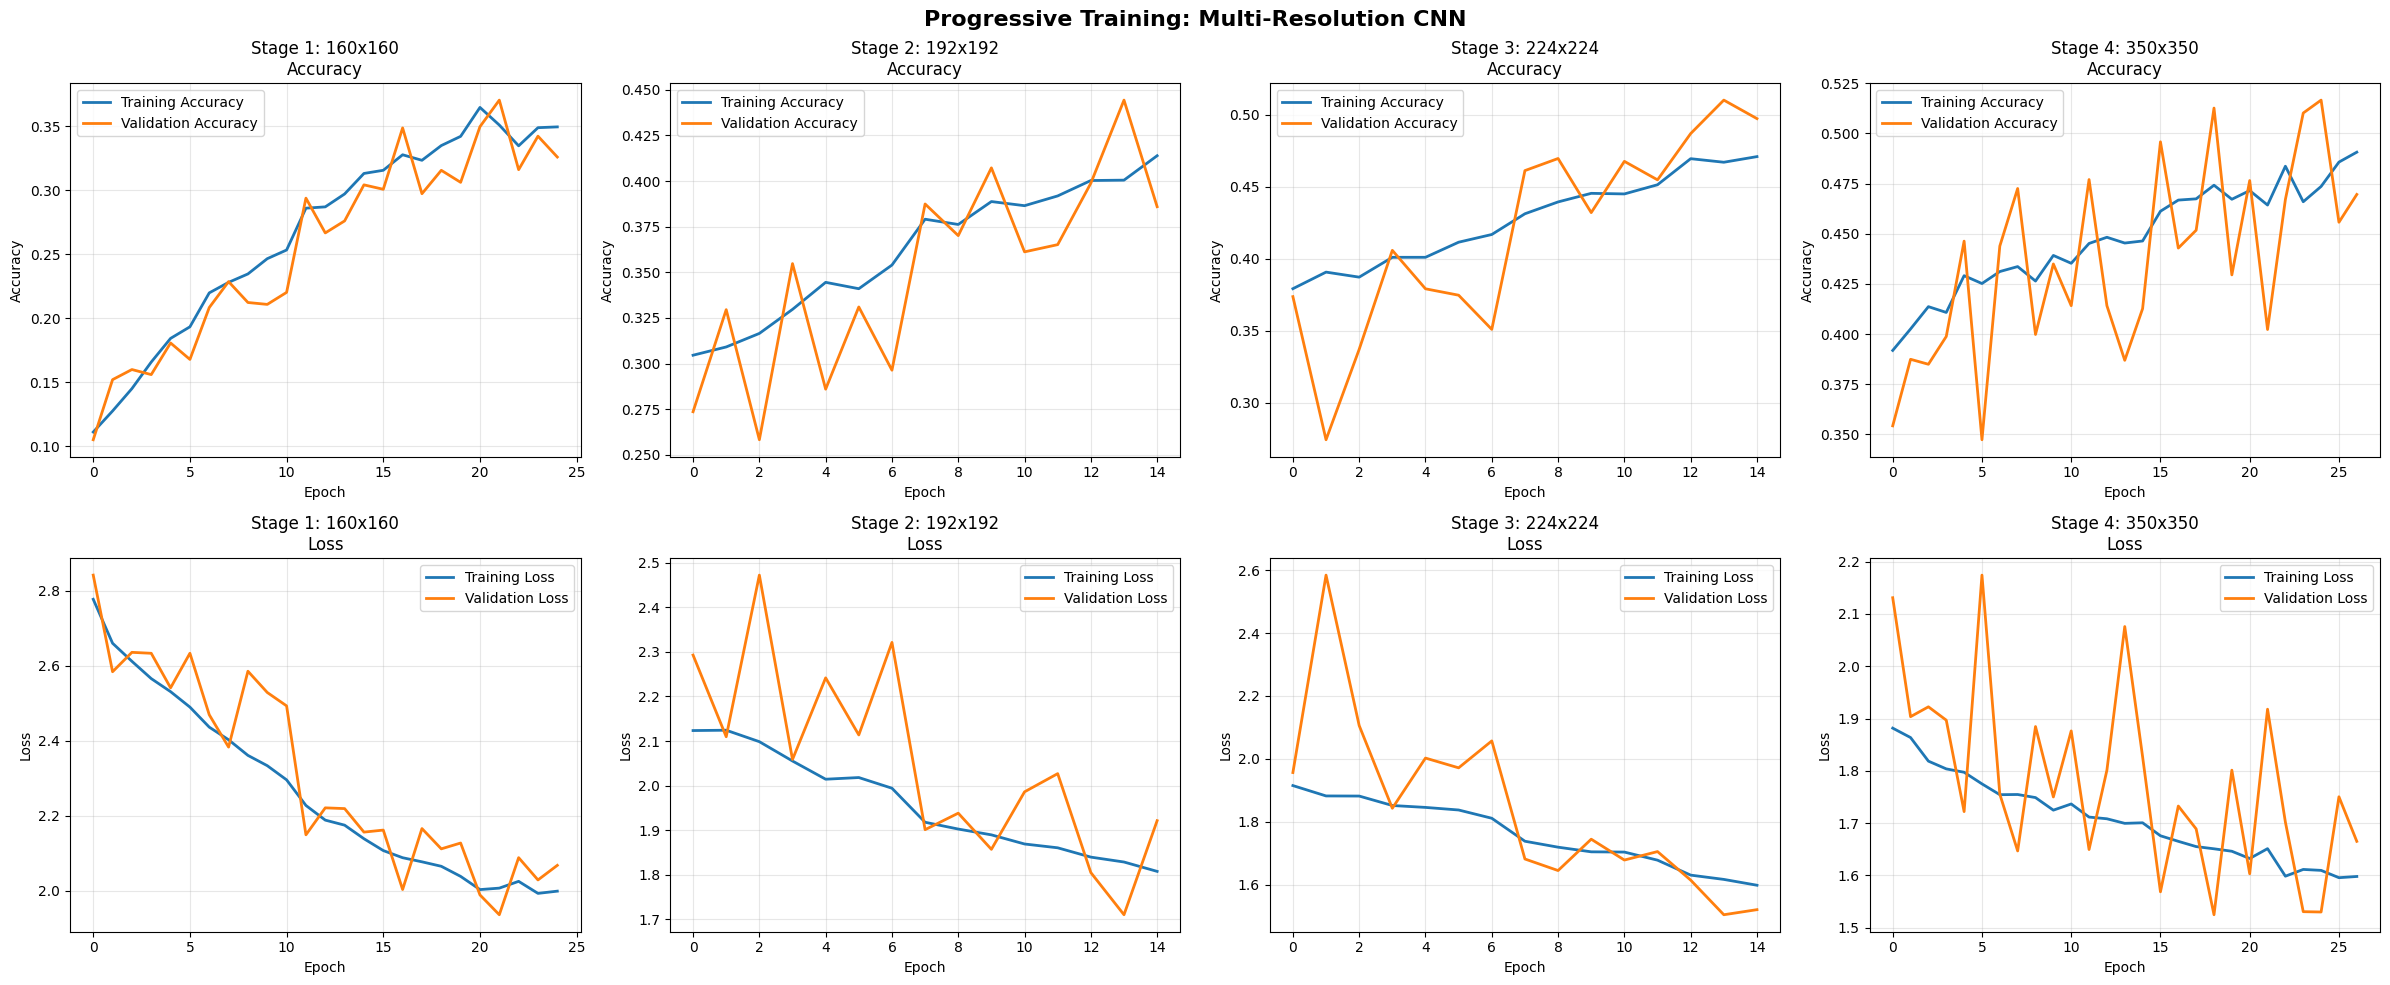


Evaluating final model (400x400) on test set...
Found 1133 images belonging to 17 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.5128 - loss: 1.4702
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.5128 - loss: 1.4702

Final Model Test Results (400x400):
Test accuracy: 0.5128
Test loss: 1.4702

Final Model Test Results (400x400):
Test accuracy: 0.5128
Test loss: 1.4702


In [ ]:
# Plot progressive training history across all stages
numStages = len(stageHistories)
fig, axes = plt.subplots(2, numStages, figsize=(6*numStages, 10))
fig.suptitle('Progressive Training: Multi-Resolution CNN', fontsize=16, fontweight='bold')

stageNames = list(stageHistories.keys())

# Handle case where there's only one stage (axes won't be 2D)
if numStages == 1:
    axes = axes.reshape(2, 1)

for idx, stageName in enumerate(stageNames):
    history = stageHistories[stageName]
    
    axAcc = axes[0, idx]
    axAcc.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axAcc.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axAcc.set_title(f'{stageName}\nAccuracy')
    axAcc.set_xlabel('Epoch')
    axAcc.set_ylabel('Accuracy')
    axAcc.legend()
    axAcc.grid(True, alpha=0.3)
    
    axLoss = axes[1, idx]
    axLoss.plot(history.history['loss'], label='Training Loss', linewidth=2)
    axLoss.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axLoss.set_title(f'{stageName}\nLoss')
    axLoss.set_xlabel('Epoch')
    axLoss.set_ylabel('Loss')
    axLoss.legend()
    axLoss.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

finalSize = trainingStages[-1]['img_size']
print(f"\nEvaluating final model ({finalSize}x{finalSize}) on test set...")

testDatagenFinal = ImageDataGenerator(preprocessing_function=simplePreprocessing)
testGeneratorEval = testDatagenFinal.flow_from_directory(
    f'{outputFolder}/test',
    target_size=(finalSize, finalSize),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

testLoss, testAccuracy = model.evaluate(testGeneratorEval, verbose=1)
print(f"\nFinal Model Test Results ({finalSize}x{finalSize}):")
print(f"Test accuracy: {testAccuracy:.4f}")
print(f"Test loss: {testLoss:.4f}")

def predictSnake(imagePath, modelToUse=model):
    finalSize = trainingStages[-1]['img_size']
    img = tf.keras.preprocessing.image.load_img(
        imagePath, target_size=(finalSize, finalSize)
    )
    imgArray = tf.keras.preprocessing.image.img_to_array(img)
    imgArray = np.expand_dims(imgArray, 0)
    imgArray = simplePreprocessing(imgArray)
    
    predictions = modelToUse.predict(imgArray)
    predictedClass = np.argmax(predictions[0])
    confidence = predictions[0][predictedClass]
    
    classNames = list(trainGenerator.class_indices.keys())
    predictedSnake = classNames[predictedClass]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predictedSnake}\nConfidence: {confidence:.2%}')
    plt.show()
    
    top3Idx = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 predictions:")
    for idx in top3Idx:
        print(f"{classNames[idx]}: {predictions[0][idx]:.2%}")

Loaded both model_stage_224.keras and model_stage_400.keras
Found 4 images in Testing Snake

Testing: test.png
------------------------------------------------------------
224x224 Model: Ring-Necked Snake (50.01%)
400x400 Model: Ring-Necked Snake (66.62%)
224x224 Model: Ring-Necked Snake (50.01%)
400x400 Model: Ring-Necked Snake (66.62%)


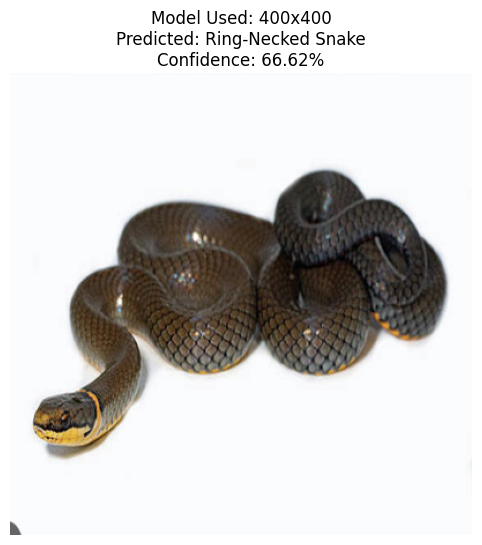

Model Used: 400x400
Top 3 predictions (combined from both models):
  1. Ring-Necked Snake: 66.62%
  2. Northern Black Racer Snake: 16.69%
  3. Black Rat Snake: 11.43%

Testing: test2.jpg
------------------------------------------------------------
224x224 Model: Eastern Worm Snake (82.76%)
400x400 Model: Eastern Worm Snake (71.28%)
224x224 Model: Eastern Worm Snake (82.76%)
400x400 Model: Eastern Worm Snake (71.28%)


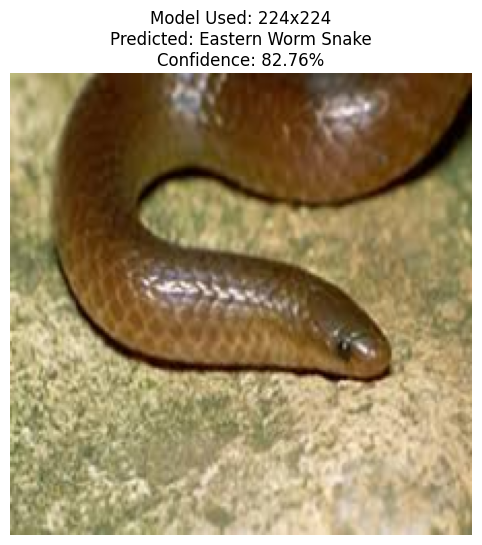

Model Used: 224x224
Top 3 predictions (combined from both models):
  1. Eastern Worm Snake: 82.76%
  2. Northern Brown Snake: 16.16%
  3. Queen Snake: 3.77%

Testing: test3.jpg
------------------------------------------------------------
224x224 Model: Northern Brown Snake (69.64%)
400x400 Model: Northern Brown Snake (80.46%)
224x224 Model: Northern Brown Snake (69.64%)
400x400 Model: Northern Brown Snake (80.46%)


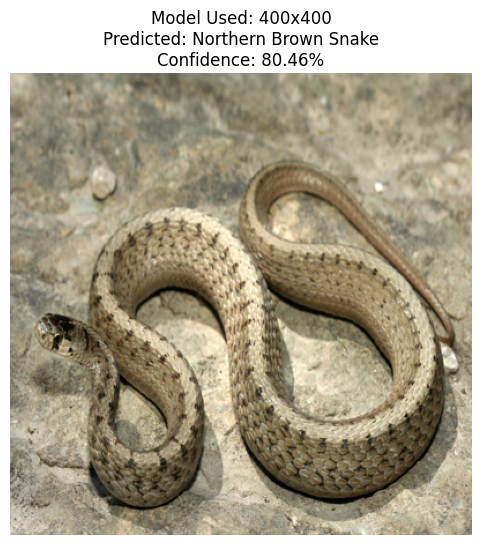

Model Used: 400x400
Top 3 predictions (combined from both models):
  1. Northern Brown Snake: 80.46%
  2. Queen Snake: 10.86%
  3. Eastern Worm Snake: 10.37%

Testing: test4.jpg
------------------------------------------------------------
224x224 Model: Black Rat Snake (21.36%)
400x400 Model: Northern Brown Snake (26.06%)
224x224 Model: Black Rat Snake (21.36%)
400x400 Model: Northern Brown Snake (26.06%)


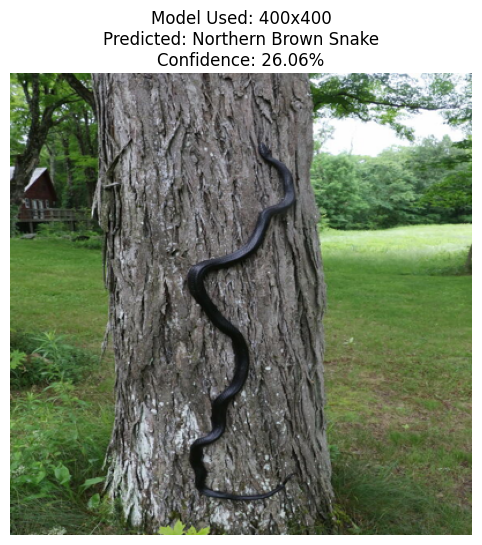

Model Used: 400x400
Top 3 predictions (combined from both models):
  1. Northern Brown Snake: 26.06%
  2. Black Rat Snake: 21.36%
  3. Eastern Hognose Snake: 14.53%


In [ ]:

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load both models from disk
model224 = tf.keras.models.load_model('model_stage_224.keras')
model400 = tf.keras.models.load_model('model_stage_400.keras')
print("Loaded both model_stage_224.keras and model_stage_400.keras")

def predictSnakeDual(imagePath):
    """Predict using both 224x224 and 400x400 models, show the one with higher confidence"""
    
    # Load the base image once and convert to RGB (removes alpha channel if present)
    from PIL import Image
    baseImg = Image.open(imagePath).convert('RGB')
    
    # Resize and preprocess for 224x224 model
    img224 = baseImg.resize((224, 224))
    imgArray224 = tf.keras.preprocessing.image.img_to_array(img224)
    imgArray224 = np.expand_dims(imgArray224, 0)
    imgArray224 = imgArray224 / 255.0  # simple_preprocessing
    
    # Resize and preprocess for 400x400 model
    img400 = baseImg.resize((400, 400))
    imgArray400 = tf.keras.preprocessing.image.img_to_array(img400)
    imgArray400 = np.expand_dims(imgArray400, 0)
    imgArray400 = imgArray400 / 255.0  # simple_preprocessing
    
    # Get predictions from both models
    predictions224 = model224.predict(imgArray224, verbose=0)
    predictions400 = model400.predict(imgArray400, verbose=0)
    
    # Get confidence scores and class names
    confidence224 = np.max(predictions224[0])
    confidence400 = np.max(predictions400[0])
    classNames = list(train_generator.class_indices.keys())
    
    # Show predictions from both models
    predictedClass224 = np.argmax(predictions224[0])
    predictedClass400 = np.argmax(predictions400[0])
    predictedSnake224 = classNames[predictedClass224]
    predictedSnake400 = classNames[predictedClass400]
    
    print(f"224x224 Model: {predictedSnake224} ({confidence224:.2%})")
    print(f"400x400 Model: {predictedSnake400} ({confidence400:.2%})")
    
    # Choose the model with higher confidence
    if confidence224 > confidence400:
        chosenPredictions = predictions224[0]
        chosenConfidence = confidence224
        chosenModel = "224x224"
        displayImg = img224
    else:
        chosenPredictions = predictions400[0]
        chosenConfidence = confidence400
        chosenModel = "400x400" 
        displayImg = img400
    
    # Get chosen prediction details
    predictedClass = np.argmax(chosenPredictions)
    predictedSnake = classNames[predictedClass]
    
    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(displayImg)
    plt.axis('off')
    plt.title(f'Model Used: {chosenModel}\nPredicted: {predictedSnake}\nConfidence: {chosenConfidence:.2%}')
    plt.show()
    
    # Combine predictions from both models and show top 3 overall
    combinedPredictions = {}
    
    # Add predictions from 224x224 model
    for i, confidence in enumerate(predictions224[0]):
        snakeName = classNames[i]
        combinedPredictions[snakeName] = max(combinedPredictions.get(snakeName, 0), confidence)
    
    # Add predictions from 400x400 model
    for i, confidence in enumerate(predictions400[0]):
        snakeName = classNames[i]
        combinedPredictions[snakeName] = max(combinedPredictions.get(snakeName, 0), confidence)
    
    # Sort by confidence and get top 3
    sortedPredictions = sorted(combinedPredictions.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"Model Used: {chosenModel}")
    print(f"Top 3 predictions (combined from both models):")
    for i, (snakeName, confidence) in enumerate(sortedPredictions):
        print(f"  {i+1}. {snakeName}: {confidence:.2%}")

# Test predictions on Testing Snake folder
testFolder = "Testing Snake"
imageExtensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')

if os.path.exists(testFolder):
    imageFiles = [f for f in os.listdir(testFolder) if f.lower().endswith(imageExtensions)]
    
    if imageFiles:
        print(f"Found {len(imageFiles)} images in {testFolder}")
        print("=" * 60)
        
        for imageFile in imageFiles:
            imagePath = os.path.join(testFolder, imageFile)
            print(f"\nTesting: {imageFile}")
            print("-" * 60)
            predictSnakeDual(imagePath)
    else:
        print(f"No image files found in {testFolder}")
else:
    print(f"Folder {testFolder} not found")
